<a href="https://colab.research.google.com/github/KhurramRashid6893/NLP_Airline-Tweets-Sentiment-Analysis/blob/main/Implementing_sentiment_analysis_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For Handling Data
import pandas as pd

# increase the output column width
pd.set_option('display.max_colwidth', 200)

# For numerical computing
import numpy as np

# Library for pattern matching
import re

# for NLP related tasks
import spacy
nlp=spacy.load('en_core_web_sm',disable=["tagger", "parser","ner"])

<font size=5>**Steps to Follow**</font>
1. Loading and Exploring Data
2. Text Cleaning
3. Data Preparation
    1. Label Encoding
    2. Split Data
    3. Feature Engineering using TF-IDF
4. Model Building
    1. Naive Bayes
    2. Logistic Regression
    3. Model Building Summary
5. Final Sentiment Analysis Pipeline

# Loading and Exploring Data

In [2]:
# mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# read CSV file
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/Project_Airlines_Tweets_sentiment_Analysis/Tweets.csv')

#shape of the dataframe
print('Shape=>',df.shape)

# print first 5 rows
df.head()

Shape=> (14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
# Some sample tweets
df['text'].sample(5)

,text
4450,"@SouthwestAir I have used you guys for most my travels, but this last experience I will never use southwest again! #worstcustomerservice"
10779,@USAirways Yes thank you. Appreciate u checking...
4017,@united obviously
4721,@SouthwestAir I did. Still haven't heard a thing.
12938,@AmericanAir already shared with them. Nothing done!


In [5]:
# class distribution
df['airline_sentiment'].value_counts()

,count
airline_sentiment,
negative,9178
neutral,3099
positive,2363


In [6]:
# class distribution in percentage
df['airline_sentiment'].value_counts(normalize = True)*100

,proportion
airline_sentiment,
negative,62.691257
neutral,21.168033
positive,16.140710


# Text Cleaning

In [7]:
#define a function for text cleaning
def text_cleaner(text):

  #remove user mentions
  text = re.sub(r'@[A-Za-z0-9]+','',text)

  #remove hashtags
  #text = re.sub(r'#[A-Za-z0-9]+','',text)

  #remove links
  text = re.sub(r'http\S+', '', text)

  #convering text to lower case
  text = text.lower()

  # fetch only words
  text = re.sub("[^a-z]+", " ", text)

  # removing extra spaces
  text=re.sub("[\s]+"," ",text)

  # creating doc object
  doc=nlp(text)

  # remove stopwords and lemmatize the text
  tokens=[token.lemma_ for token in doc if(token.is_stop==False)]

  #join tokens by space
  return " ".join(tokens)

<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-645049785.py:20: SyntaxWarning: invalid escape sequence '\s'
  text=re.sub("[\s]+"," ",text)


In [8]:
# perform text cleaning
df['clean_text']= df['text'].apply(text_cleaner)

/usr/local/lib/python3.12/dist-packages/spacy/pipeline/lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [9]:
# save cleaned text and labels to a variable
text   = df['clean_text'].values
labels = df['airline_sentiment'].values

In [10]:
# Sample cleaned text
text[:10]

array(['  said', '  plus ve added commercials experience tacky',
       '  didn t today mean need trip',
       '  s aggressive blast obnoxious entertainment guests faces amp little recourse',
       '  s big bad thing',
       '  seriously pay flight seats didn t playing s bad thing flying va',
       '  yes nearly time fly vx ear worm won t away',
       '  missed prime opportunity men hats parody', '  didn t d',
       '  amazing arrived hour early good'], dtype=object)

In [11]:
# Sample labels
labels[:10]

array(['neutral', 'positive', 'neutral', 'negative', 'negative',
       'negative', 'positive', 'neutral', 'positive', 'positive'],
      dtype=object)

# Data Preparation

## Label Encoding

In [12]:
#importing label encoder
from sklearn.preprocessing import LabelEncoder

#define label encoder
le = LabelEncoder()

#fit and transform target strings to a numbers
labels = le.fit_transform(labels)

In [13]:
# Sample labels
labels[:10]

array([1, 2, 1, 0, 0, 0, 2, 1, 2, 2])

In [14]:
# Meaning of each label
le.inverse_transform([0,1,2])

array(['negative', 'neutral', 'positive'], dtype=object)

## Split Data

In [15]:
from sklearn.model_selection import train_test_split

# Splitting into train and validation set
x_train,x_val,y_train,y_val=train_test_split(text, labels,stratify=labels, test_size=0.2, random_state=0,shuffle=True)

In [16]:
print('x_train:',x_train.shape,'y_train:',y_train.shape)
print('x_val:',x_val.shape,'y_val:',y_val.shape)

x_train: (11712,) y_train: (11712,)
x_val: (2928,) y_val: (2928,)


## Feature Engineering using TF-IDF

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
# initialize TFIDF
word_vectorizer = TfidfVectorizer(max_features=1000)

In [19]:
# Fitting Vectorizer on Train set
word_vectorizer.fit(x_train)

TfidfVectorizer(max_features=1000)

In [20]:
# create TF-IDF vectors for Train Set
train_word_features = word_vectorizer.transform(x_train)
train_word_features

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 65702 stored elements and shape (11712, 1000)>

In [21]:
# create TF-IDF vectors for Validation Set
val_word_features = word_vectorizer.transform(x_val)
val_word_features

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16559 stored elements and shape (2928, 1000)>

# Model Building

## Naive Bayes

In [22]:
# Importing for modeling
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score

In [23]:
# Training model
nb_model=MultinomialNB().fit(train_word_features,y_train)
nb_model

MultinomialNB()

In [24]:
# Make predictions for train set
train_pred_nb=nb_model.predict(train_word_features)

In [25]:
train_pred_nb

array([0, 0, 0, ..., 2, 0, 0])

In [26]:
# Evaluating on Training Set
print("F1-score on Train Set:",f1_score(y_train,train_pred_nb,average="weighted"))

F1-score on Train Set: 0.7306482627181051


In [27]:
# Make predictions for validation set
val_pred_nb=nb_model.predict(val_word_features)

# Evaluating on Validation Set
print("F1-score on Validation Set:",f1_score(y_val,val_pred_nb,average="weighted"))

F1-score on Validation Set: 0.6882592201984448


## Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
# Training model
lr_model=LogisticRegression().fit(train_word_features,y_train)
lr_model

LogisticRegression()

In [30]:
# Make predictions for train set
train_pred_lr=lr_model.predict(train_word_features)
train_pred_nb

array([0, 0, 0, ..., 2, 0, 0])

In [31]:
# Evaluating on Training Set
print("F1-score on Train Set:",f1_score(y_train,train_pred_lr,average="weighted"))

F1-score on Train Set: 0.8073621434953564


In [32]:
# Make predictions for validation set
val_pred_lr=lr_model.predict(val_word_features)

# Evaluating on Validation Set
print("F1-score on Validation Set:",f1_score(y_val,val_pred_lr,average="weighted"))

F1-score on Validation Set: 0.7512862286264019


## Model Building Summary
|        Model        | Train Set | Validation Set |
|:-------------------:|:---------:|:--------------:|
|     Naive Bayes     |   0.7274  |     0.6791     |
| Logistic Regression |   0.8089  |     0.7598     |

It is evident from the results that Logistic Regression performs better than Naive Bayes on this dataset.

# Final Sentiment Analysis Pipeline

In [33]:
def sentiment_analyzer(tweet):
  # Cleaning Tweet
  cleaned_tweet=text_cleaner(tweet)

  # Feature Engineering
  tweet_vector=word_vectorizer.transform([cleaned_tweet])

  # Predicting Sentiment
  label=lr_model.predict(tweet_vector)

  return le.inverse_transform(np.array(label))

<font size=4>**Sample Tweet:**</font>
<p>@USAirways flt 419. 2+ hrs Late Flight, baggage + 1 more hr. Now I see they delivered my suitcase wet inside &amp; out. #NotHappy</p>

In [34]:
sentiment_analyzer("@USAirways flt 419. 2+ hrs Late Flight, baggage + 1 more hr. Now I see they delivered my suitcase wet inside &amp; out. #NotHappy")

/usr/local/lib/python3.12/dist-packages/spacy/pipeline/lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


array(['negative'], dtype=object)

/tmp/ipython-input-3135713490.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='airline_sentiment', data=df, palette='viridis')


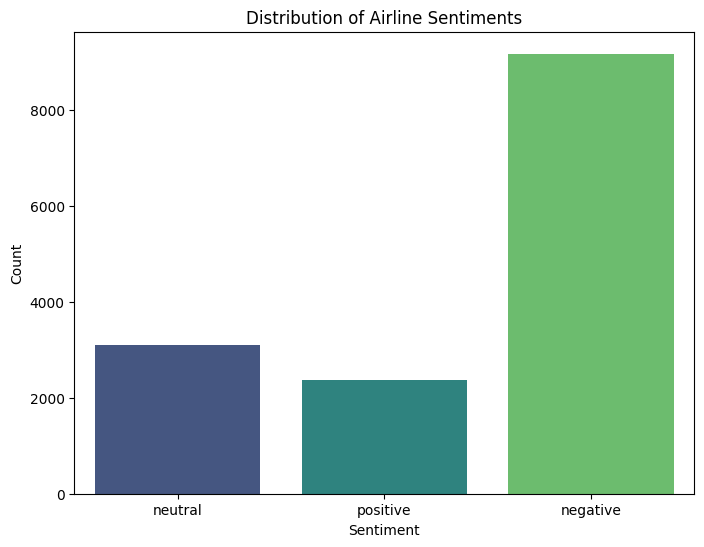

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of airline sentiments
plt.figure(figsize=(8, 6))
sns.countplot(x='airline_sentiment', data=df, palette='viridis')
plt.title('Distribution of Airline Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

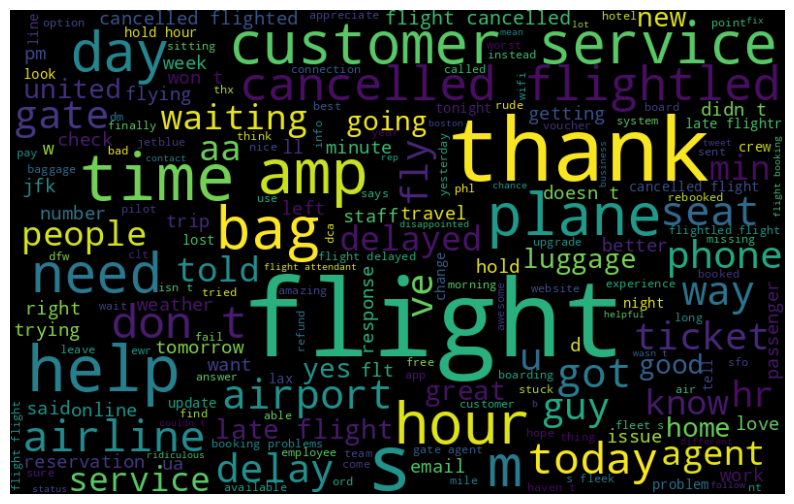

In [37]:
from wordcloud import WordCloud

# Join all the cleaned tweets into a single string
all_words = ' '.join([text for text in df['clean_text']])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

# Plot the word cloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()